### Imports

In [7]:
# Import necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


### Import data

In [8]:
df = pd.read_csv('../../data/data.csv')

df = df.drop(['Country', 'Region', 'Year'], axis=1)

X = df.drop('Life_expectancy', axis=1)
y = df['Life_expectancy']

# Bin 'Life_expectancy' into intervals of 5 years from 40 to 85
bins = np.arange(40, 90, 5)
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins) - 1)]
df['Life_expectancy_bin'] = pd.cut(df['Life_expectancy'], bins=bins, labels=bin_labels, right=False)

# Encode categorical variables using LabelEncoder
label_encoders = {}
encoded_df = df.copy()
for col in encoded_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col])
    label_encoders[col] = le

# Define features and target variable
X = encoded_df.drop(columns=['Life_expectancy', 'Life_expectancy_bin'])
y_binned = encoded_df['Life_expectancy_bin']  # Binned target for SMOTE
y_continuous = encoded_df['Life_expectancy']  # Continuous target for regression

# Drop rows with missing target labels
X = X[y_binned.notnull()]
y_binned = y_binned[y_binned.notnull()]
y_continuous = y_continuous[y_binned.index]

# Encode binned target for SMOTE
y_binned_encoded = y_binned.astype('category').cat.codes

# Split data into training and testing sets
X_train_binned, X_test_binned, y_train_binned, y_test_binned = train_test_split(X, y_binned_encoded, test_size=0.2, random_state=1)
_, _, y_train_continuous, y_test_continuous = train_test_split(
    X, y_continuous, test_size=0.2, random_state=1
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
X_resampled, y_resampled_binned = smote.fit_resample(X_train_binned, y_train_binned)

# Map resampled binned target back to continuous target values
y_resampled_continuous = pd.Series(y_resampled_binned).map(
    dict(zip(range(len(bin_labels)), bins[:-1] + 2.5))
)
y_resampled_continuous = y_resampled_continuous.astype(float)

# Scale the resampled training data and original test data
scaler = StandardScaler()
X_train_scaled_binned = scaler.fit_transform(X_resampled)
X_test_scaled_binned = scaler.transform(X_test_binned)

# # Save column names for reference after train/test split
feature_names = X.columns.tolist()

# Convert scaled arrays back to DataFrame
X_train_df = pd.DataFrame(X_train_scaled_binned, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled_binned, columns=feature_names)

## Feature selection

### _Checking regression model accuracy metrics for optimal numbers of features_

Using a Sequential forward selection to find the best subsets both on the transformed data and the original data

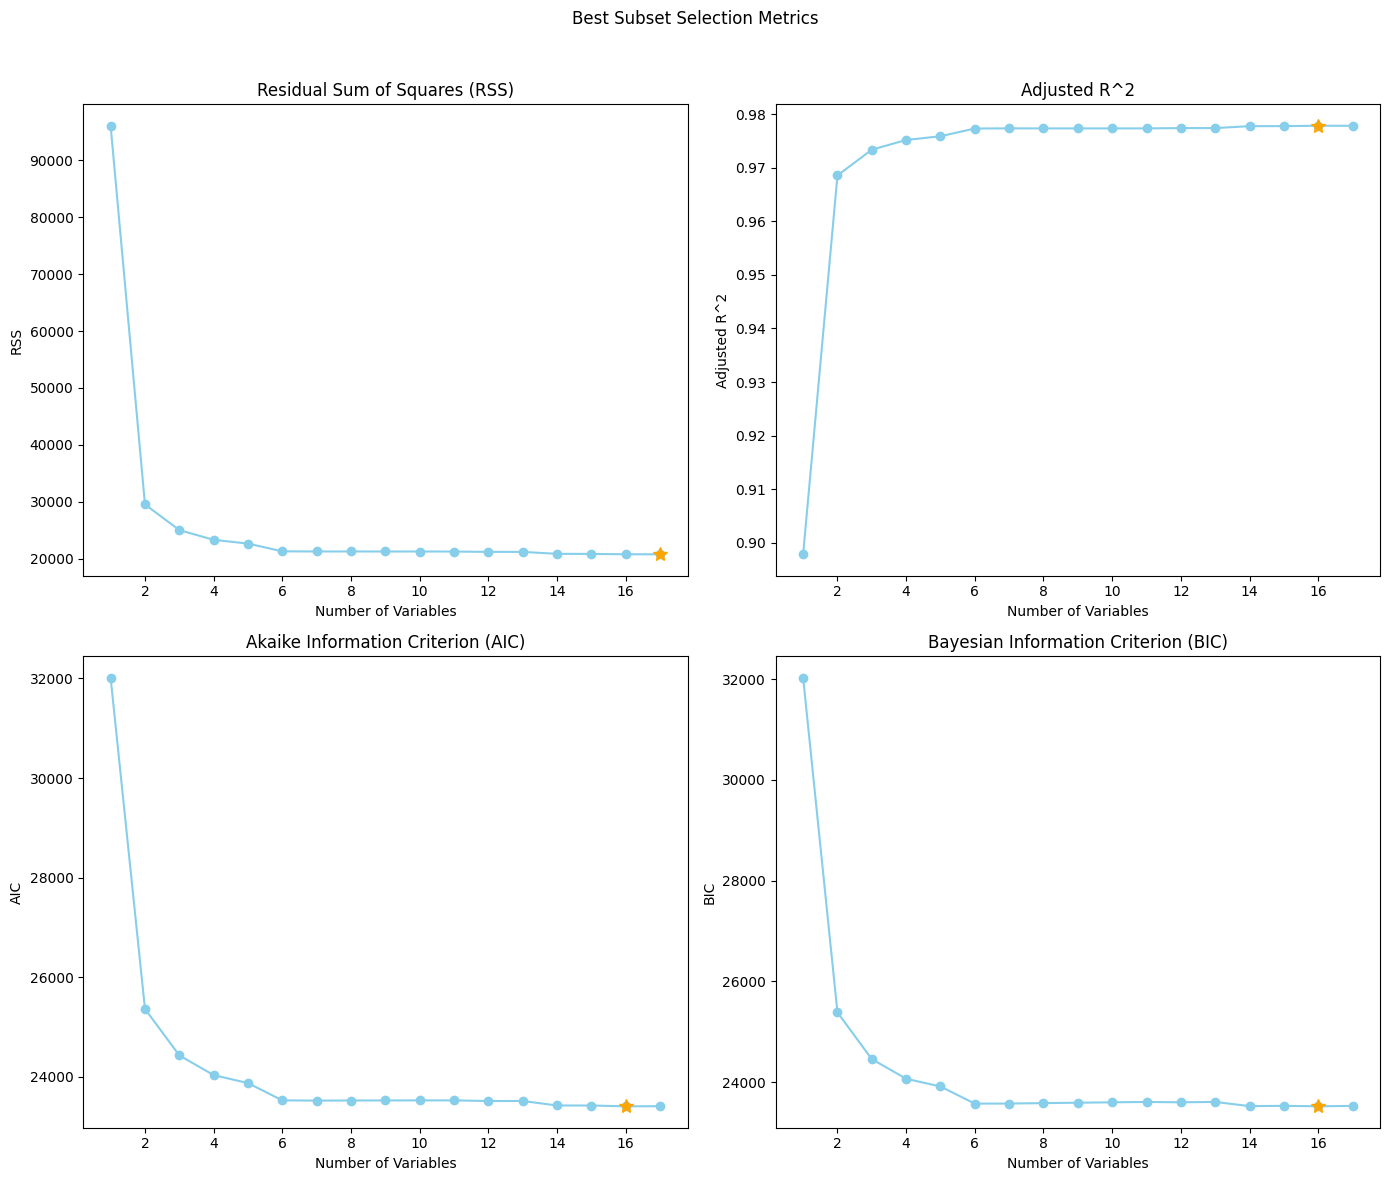

In [9]:
# Define the regression model
model = LinearRegression()

# Sequential feature selection to find best subsets up to all features
sfs_reg = SFS(model,
          k_features=(1, X_train_df.shape[1]),  # Test from 1 feature up to all features
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)

# Fit SFS on the binned data
sfs_reg = sfs_reg.fit(X_train_df, y_resampled_continuous)

# Get the selection results for each subset size
results = sfs_reg.subsets_

# Initialize lists to store metrics for each subset size
rss_list = []
adj_r2_list = []
aic_list = []
bic_list = []
cp_list = []

# Total number of observations
n = X_train_df.shape[0]

# Calculate metrics for each subset
for subset_size in range(1, X_train_df.shape[1] + 1):
    # Extract selected feature indices for the current subset size
    selected_features_rg = list(results[subset_size]['feature_idx'])
    X_subset_rg = X_train_df.iloc[:, selected_features_rg]
    
    # Add a constant term for OLS regression
    X_subset_const_rg = add_constant(X_subset_rg)
    
    # Fit an OLS model and gather stats
    ols_model = OLS(y_resampled_continuous, X_subset_const_rg).fit()
    
    # Residual Sum of Squares (RSS)
    rss = ((ols_model.resid) ** 2).sum()
    rss_list.append(rss)
    
    # Adjusted R^2
    adj_r2_list.append(ols_model.rsquared_adj)
    
    # Akaike Information Criterion (AIC)
    aic_list.append(ols_model.aic)
    
    # Bayesian Information Criterion (BIC)
    bic_list.append(ols_model.bic)
    
    # Mallows' Cp
    mse_full = rss / (n - subset_size - 1)  # Mean squared error
    cp = rss / mse_full - (n - 2 * subset_size)
    cp_list.append(cp)

# Plotting metrics to find optimal subset size
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Best Subset Selection Metrics')

# Define a unified color for all plots
plot_color = 'skyblue'

# Plot RSS
axes[0, 0].plot(range(1, X_train_df.shape[1] + 1), rss_list, marker='o', color=plot_color)
axes[0, 0].set_xlabel('Number of Variables')
axes[0, 0].set_ylabel('RSS')
axes[0, 0].set_title('Residual Sum of Squares (RSS)')
axes[0, 0].plot(len(rss_list), rss_list[-1], marker='*', markersize=10, color="orange")  # Mark minimum RSS point

# Plot Adjusted R^2
axes[0, 1].plot(range(1, X_train_df.shape[1] + 1), adj_r2_list, marker='o', color=plot_color)
axes[0, 1].set_xlabel('Number of Variables')
axes[0, 1].set_ylabel('Adjusted R^2')
axes[0, 1].set_title('Adjusted R^2')
max_adjr2_idx = np.argmax(adj_r2_list) + 1
axes[0, 1].plot(max_adjr2_idx, adj_r2_list[max_adjr2_idx - 1], marker='*', markersize=10, color="orange")  # Mark max Adjusted R² point

# Plot AIC
axes[1, 0].plot(range(1, X_train_df.shape[1] + 1), aic_list, marker='o', color=plot_color)
axes[1, 0].set_xlabel('Number of Variables')
axes[1, 0].set_ylabel('AIC')
axes[1, 0].set_title('Akaike Information Criterion (AIC)')
min_aic_idx = np.argmin(aic_list) + 1
axes[1, 0].plot(min_aic_idx, aic_list[min_aic_idx - 1], marker='*', markersize=10, color="orange")  # Mark minimum AIC point

# Plot BIC
axes[1, 1].plot(range(1, X_train_df.shape[1] + 1), bic_list, marker='o', color=plot_color)
axes[1, 1].set_xlabel('Number of Variables')
axes[1, 1].set_ylabel('BIC')
axes[1, 1].set_title('Bayesian Information Criterion (BIC)')
min_bic_idx = np.argmin(bic_list) + 1
axes[1, 1].plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Mark minimum BIC point

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### _Forward selection_

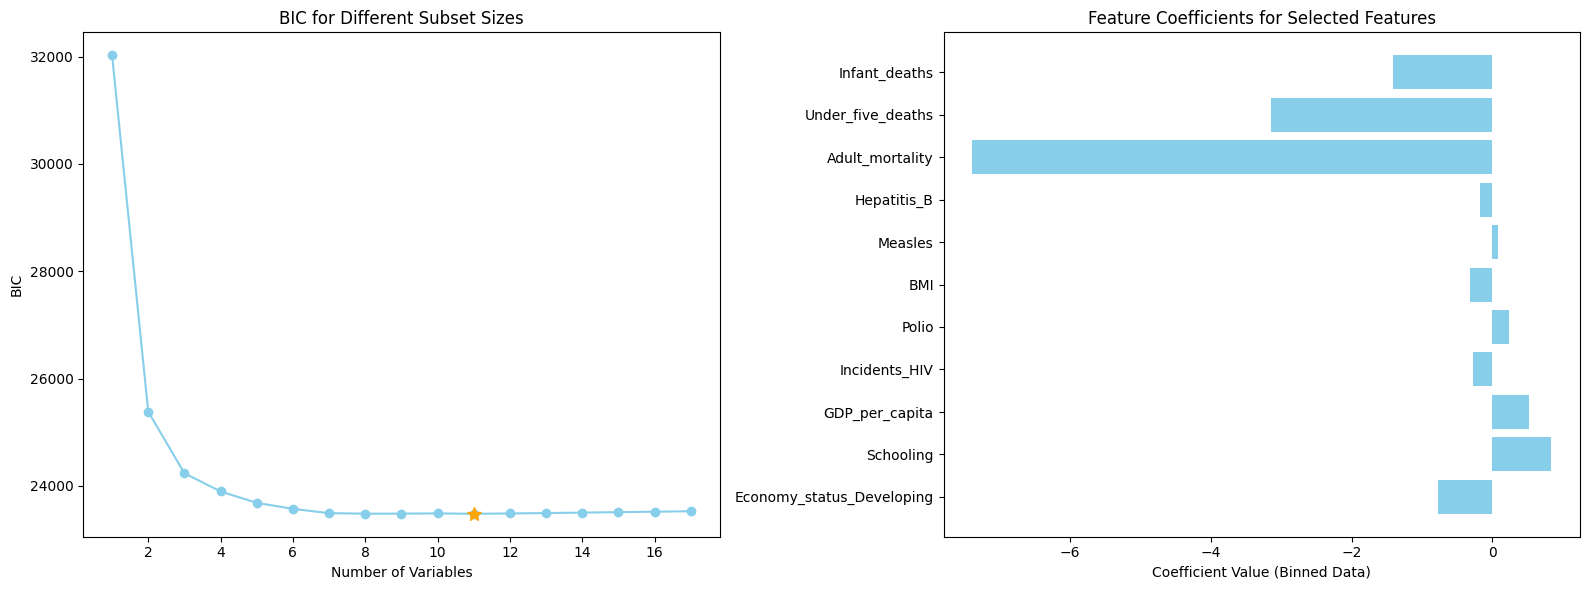

In [10]:
# Step 1: Forward Selection for Subset Selection with transformed data
model = LinearRegression()
sfs_fw = SFS(model,
          k_features=(1, X_train_df.shape[1]),  # Test from 1 feature up to max features
          forward=True,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs_fw = sfs_fw.fit(X_train_df, y_resampled_continuous)

# Step 2: Calculating BIC for each subset with binned data
bic_list = []
n = len(y_resampled_continuous)

for subset_size in range(1, X_train_df.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs_fw.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train_df.iloc[:, selected_features]
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_resampled_continuous, X_subset_const).fit()
    bic_list.append(ols_model.bic)
    
# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train_df.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Refit the model on the optimal subset using the original target y
optimal_features_bl_fw = list(sfs_fw.subsets_[min_bic_idx]['feature_idx'])  # Get indices of optimal features
optimal_feature_names = [feature_names[i] for i in optimal_features_bl_fw]  # Get names of these features

# Re-fit on the original target variable y for interpretability
X_optimal_bl = X_train_df.iloc[:, optimal_features_bl_fw]  # Optimal features from training set
X_optimal_df = pd.DataFrame(X_optimal_bl, columns=optimal_feature_names)  # Convert to DataFrame for easier plotting
model.fit(X_optimal_df, y_resampled_continuous)
coefficients = model.coef_

# Plotting the coefficients
ax2.barh(optimal_feature_names, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value (Binned Data)')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### _Backward Selection_

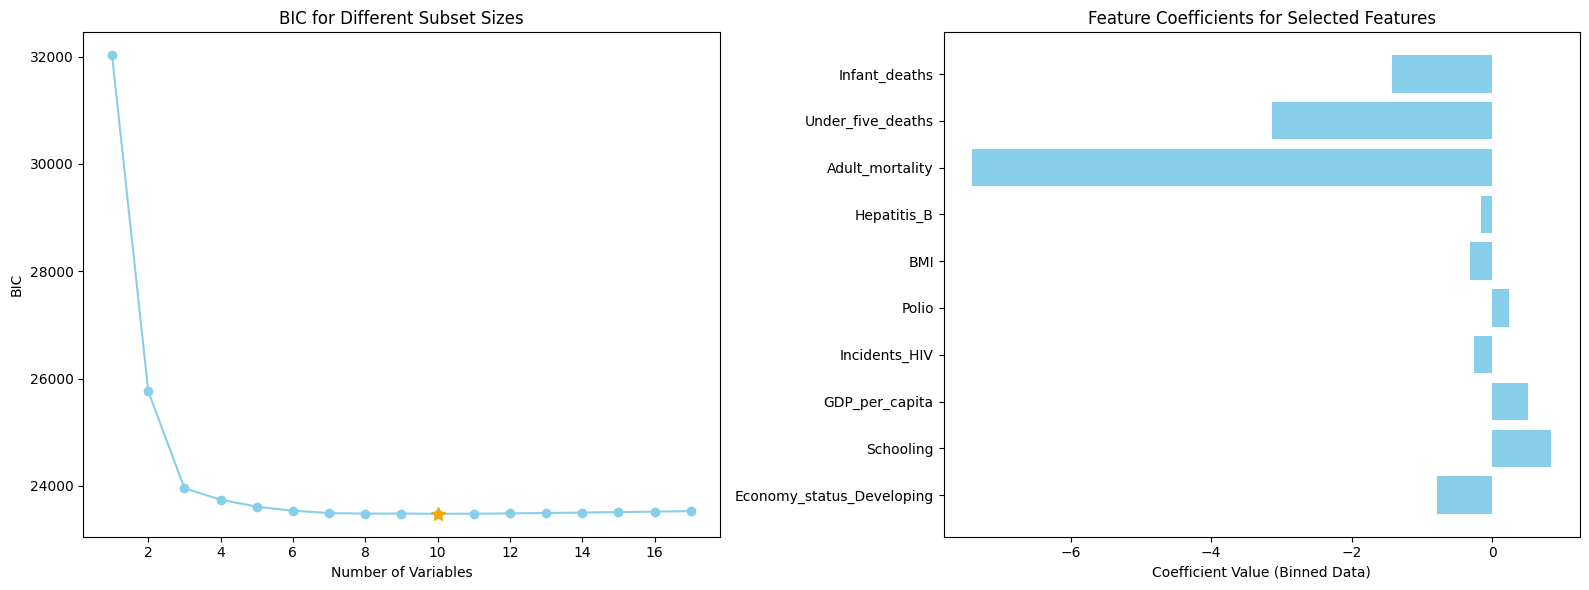

In [11]:
# Step 1: Forward Selection for Subset Selection with transformed data
model = LinearRegression()
sfs_bw = SFS(model,
          k_features=(1, X_train_df.shape[1]),  # Test from 1 feature up to max features
          forward=False,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs_bw = sfs_bw.fit(X_train_df, y_resampled_continuous)

# Step 2: Calculating BIC for each subset with transformed data
bic_list = []
n = len(y_resampled_continuous)

for subset_size in range(1, X_train_df.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs_bw.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train_df.iloc[:, selected_features]
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_resampled_continuous, X_subset_const).fit()
    bic_list.append(ols_model.bic)
    
# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train_df.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Refit the model on the optimal subset using the original target y
optimal_features_bl_bw = list(sfs_bw.subsets_[min_bic_idx]['feature_idx'])  # Get indices of optimal features
optimal_feature_names = [feature_names[i] for i in optimal_features_bl_bw]  # Get names of these features

# Re-fit on the original target variable y for interpretability
X_optimal_bl = X_train_df.iloc[:, optimal_features_bl_bw]  # Optimal features from training set
X_optimal_df = pd.DataFrame(X_optimal_bl, columns=optimal_feature_names)  # Convert to DataFrame for easier plotting
model.fit(X_optimal_df, y_resampled_continuous)
coefficients = model.coef_

# Plotting the coefficients
ax2.barh(optimal_feature_names, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value (Binned Data)')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Original Data

### _Import Data_

In [12]:
df = pd.read_csv('../../data/data.csv')

X_og = df.drop(columns=['Country', 'Region', 'Year', 'Life_expectancy'])
y_og = df['Life_expectancy']

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y_og, test_size=0.2, random_state=42)

### _Checking regression model accuracy metrics for optimal numbers of features_

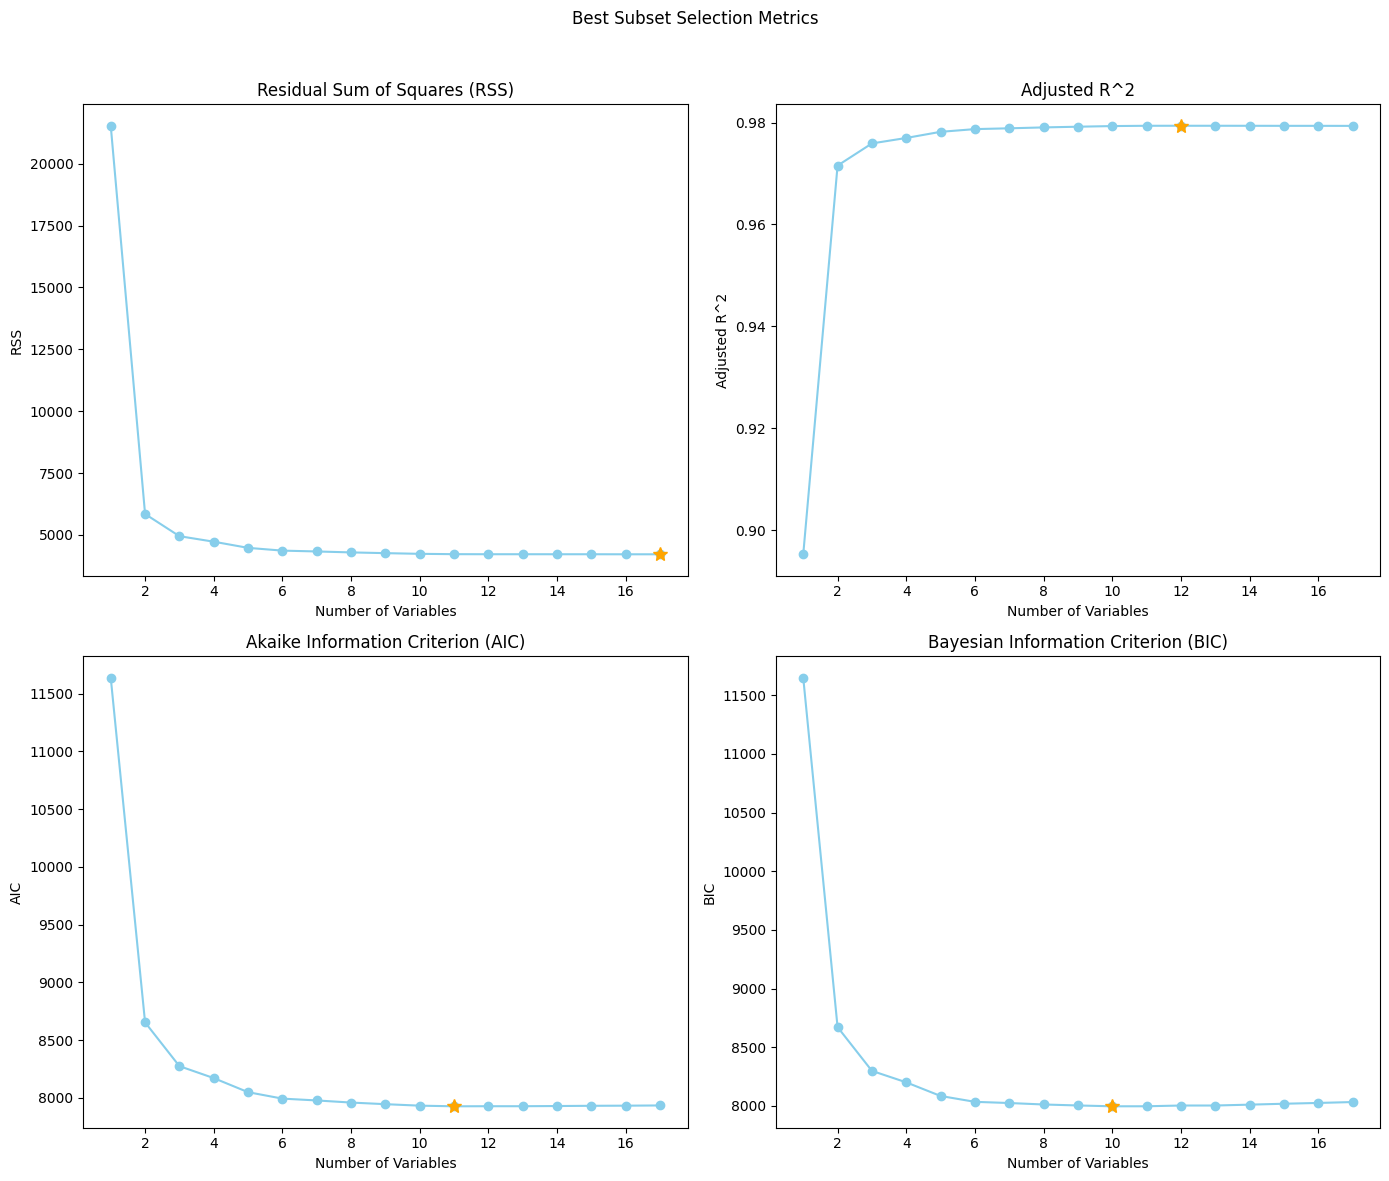

In [13]:
# Define the regression model
model = LinearRegression()

# Sequential forward selection to find best subsets up to all features
sfs = SFS(model,
          k_features=(1, X_train_og.shape[1]),  # Test from 1 feature up to all features
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)

# Fit SFS on the data
sfs = sfs.fit(X_train_og, y_train_og)

# Get the selection results for each subset size
results = sfs.subsets_

# Ensure X is a NumPy array
X_train_og = np.array(X_train_og)

# Initialize lists to store metrics for each subset size
rss_list = []
adj_r2_list = []
aic_list = []
bic_list = []
cp_list = []

# Total number of observations
n = X_train_og.shape[0]

# Calculate metrics for each subset
for subset_size in range(1, X_train_og.shape[1] + 1):
    # Extract selected feature indices for the current subset size
    selected_features = list(results[subset_size]['feature_idx'])
    X_subset = X_train_og[:, selected_features]
    
    # Add a constant term for OLS regression
    X_subset_const = add_constant   (X_subset)
    
    # Fit an OLS model and gather stats
    ols_model = OLS(y_train_og, X_subset_const).fit()
    
    # Residual Sum of Squares (RSS)
    rss = ((ols_model.resid) ** 2).sum()
    rss_list.append(rss)
    
    # Adjusted R^2
    adj_r2_list.append(ols_model.rsquared_adj)
    
    # Akaike Information Criterion (AIC)
    aic_list.append(ols_model.aic)
    
    # Bayesian Information Criterion (BIC)
    bic_list.append(ols_model.bic)
    
    # Mallows' Cp
    mse_full = rss / (n - subset_size - 1)  # Mean squared error
    cp = rss / mse_full - (n - 2 * subset_size)
    cp_list.append(cp)

# Plotting metrics to find optimal subset size
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Best Subset Selection Metrics')

# Define a unified color for all plots
plot_color = 'skyblue'

# Plot RSS
axes[0, 0].plot(range(1, X_train_og.shape[1] + 1), rss_list, marker='o', color=plot_color)
axes[0, 0].set_xlabel('Number of Variables')
axes[0, 0].set_ylabel('RSS')
axes[0, 0].set_title('Residual Sum of Squares (RSS)')
axes[0, 0].plot(len(rss_list), rss_list[-1], marker='*', markersize=10, color="orange")  # Mark minimum RSS point

# Plot Adjusted R^2
axes[0, 1].plot(range(1, X_train_og.shape[1] + 1), adj_r2_list, marker='o', color=plot_color)
axes[0, 1].set_xlabel('Number of Variables')
axes[0, 1].set_ylabel('Adjusted R^2')
axes[0, 1].set_title('Adjusted R^2')
max_adjr2_idx = np.argmax(adj_r2_list) + 1
axes[0, 1].plot(max_adjr2_idx, adj_r2_list[max_adjr2_idx - 1], marker='*', markersize=10,  color="orange")  # Mark max Adjusted R² point

# Plot AIC
axes[1, 0].plot(range(1, X_train_og.shape[1] + 1), aic_list, marker='o', color=plot_color)
axes[1, 0].set_xlabel('Number of Variables')
axes[1, 0].set_ylabel('AIC')
axes[1, 0].set_title('Akaike Information Criterion (AIC)')
min_aic_idx = np.argmin(aic_list) + 1
axes[1, 0].plot(min_aic_idx, aic_list[min_aic_idx - 1], marker='*', markersize=10, color="orange")  # Mark minimum AIC point

# Plot BIC
axes[1, 1].plot(range(1, X_train_og.shape[1] + 1), bic_list, marker='o', color=plot_color)
axes[1, 1].set_xlabel('Number of Variables')
axes[1, 1].set_ylabel('BIC')
axes[1, 1].set_title('Bayesian Information Criterion (BIC)')
min_bic_idx = np.argmin(bic_list) + 1
axes[1, 1].plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*',markersize=10, color="orange")  # Mark minimum BIC point

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### _Backward Selection_

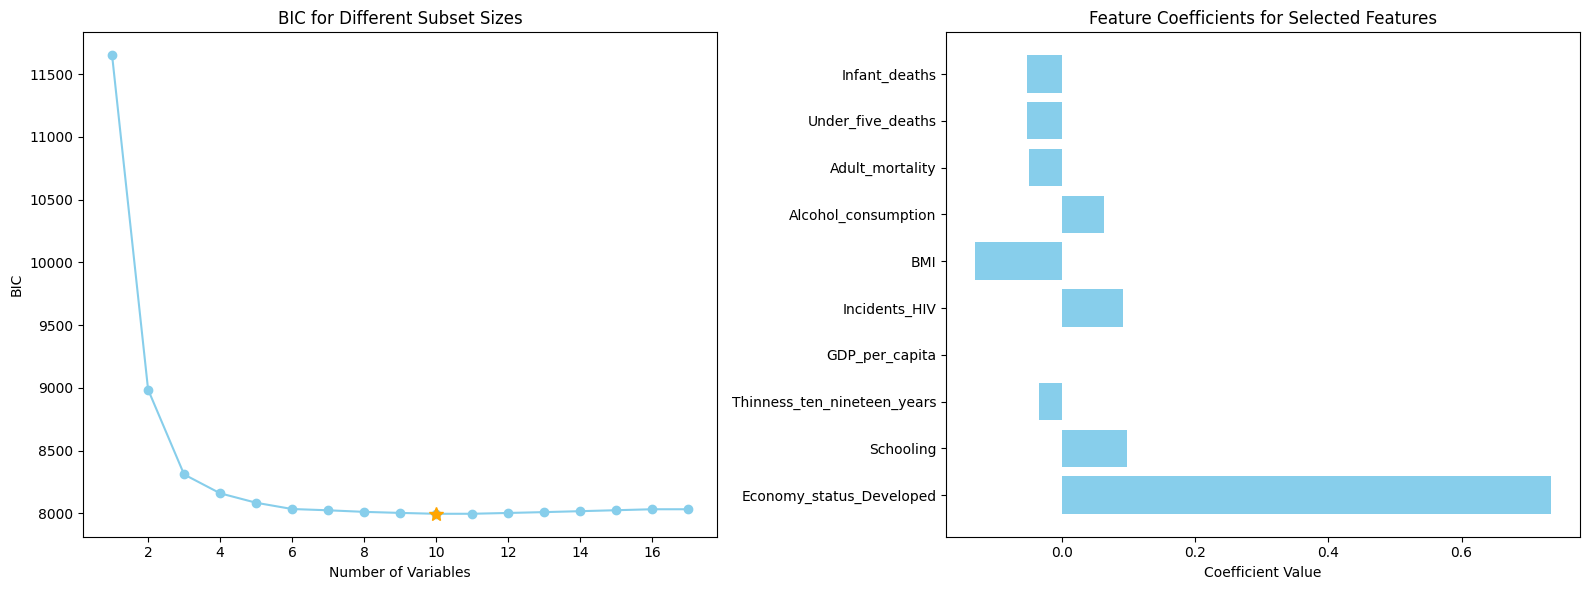

In [14]:
# Step 1: Backward Selection for Subset Selection
model = LinearRegression()
sfs = SFS(model,
          k_features=(1, X_train_og.shape[1]),  # Test from 1 feature up to max features
          forward=False,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs = sfs.fit(X_train_og, y_train_og)

# Step 2: Calculating BIC for each subset
bic_list = []
n = len(y_train_og)

for subset_size in range(1, X_train_og.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train_og[:, selected_features] 
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train_og, X_subset_const).fit()
    bic_list.append(ols_model.bic)

# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train_og.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Plot the selected features in the optimal subset on the second subplot
optimal_features_og_bw = sfs.subsets_[min_bic_idx]['feature_idx']  # Get indices of optimal features

# Fit the model on the optimal subset
X_optimal = X_train_og[:, list(optimal_features_og_bw)]
model.fit(X_optimal, y_train_og)
coefficients = model.coef_
feature_names_og = X_og.columns[list(optimal_features_og_bw)]

# Plotting the coefficients
ax2.barh(feature_names_og, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### _Forward Selection_

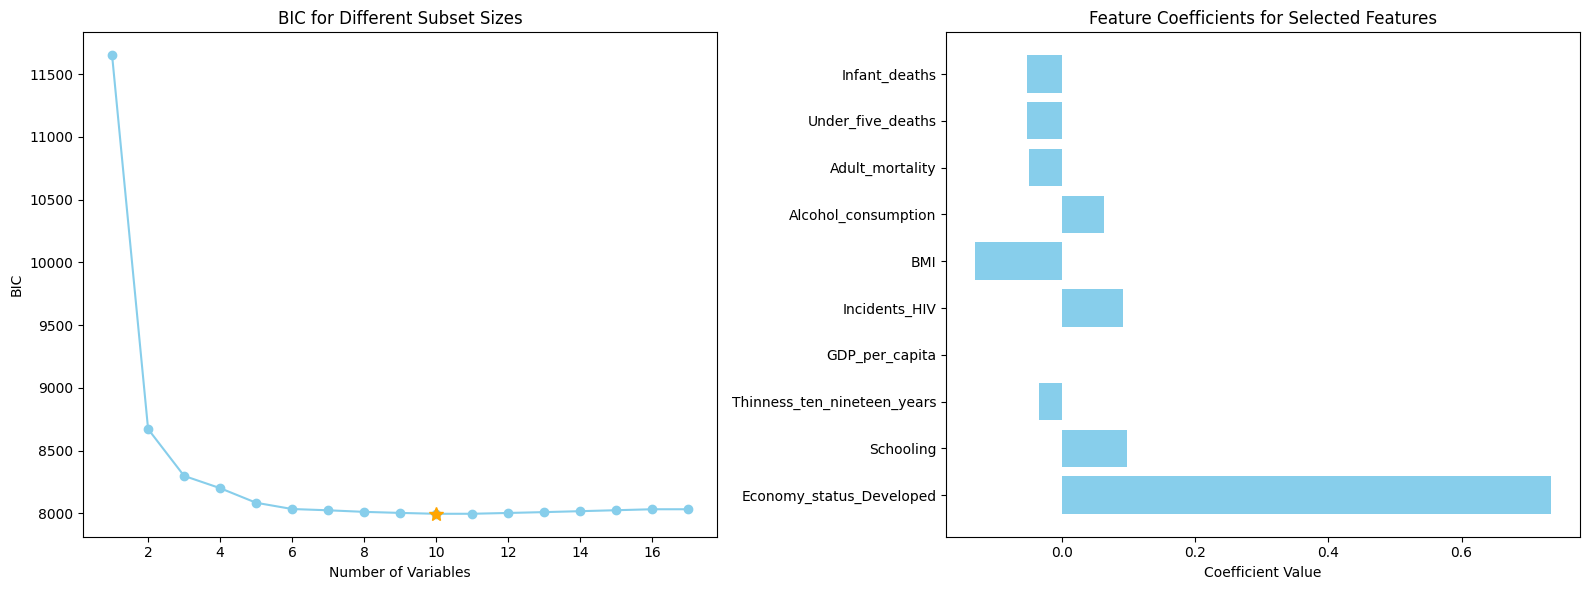

In [15]:
# Step 1: Backward Selection for Subset Selection
model = LinearRegression()
sfs = SFS(model,
          k_features=(1, X_train_og.shape[1]),  # Test from 1 feature up to max features
          forward=True,
          floating=False,
          scoring='r2',
          cv=0)  # Setting cv=0 to get direct estimates without cross-validation for BIC

sfs = sfs.fit(X_train_og, y_train_og)

# Step 2: Calculating BIC for each subset
bic_list = []
n = len(y_train_og)

for subset_size in range(1, X_train_og.shape[1] + 1):  # Loop through all possible subset sizes
    selected_features = list(sfs.subsets_[subset_size]['feature_idx'])  # Get the selected features for each subset size
    X_subset = X_train_og[:, selected_features] 
    
    # Add constant term to the subset (for intercept)
    X_subset_const = add_constant(X_subset)
    
    # Fit OLS model and calculate BIC
    ols_model = OLS(y_train_og, X_subset_const).fit()
    bic_list.append(ols_model.bic)

# Step 3: Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot BIC on the first subplot
ax1.plot(range(1, X_train_og.shape[1] + 1), bic_list, marker='o', linestyle='-', color='skyblue', label='BIC')
ax1.set_xlabel('Number of Variables')
ax1.set_ylabel('BIC')
ax1.set_title('BIC for Different Subset Sizes')

# Mark the minimum BIC point
min_bic_idx = np.argmin(bic_list) + 1  # Index of minimum BIC
ax1.plot(min_bic_idx, bic_list[min_bic_idx - 1], marker='*', markersize=10, color="orange")  # Marking minimum BIC point in red

# Step 4: Plot the selected features in the optimal subset on the second subplot
optimal_features_og_fw = sfs.subsets_[min_bic_idx]['feature_idx']  # Get indices of optimal features
feature_names_og = X_og.columns[list(optimal_features_og_fw)]      # Get names of these features

# Fit the model on the optimal subset
X_optimal = X_train_og[:, list(optimal_features_og_fw)]
model.fit(X_optimal, y_train_og)
coefficients = model.coef_

# Plotting the coefficients
ax2.barh(feature_names_og, coefficients, color='skyblue')
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Feature Coefficients for Selected Features')
ax2.invert_yaxis()  # Reverse order to have the first selected feature on top

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Models

R² Score on Original Data: 0.9776 for Original Data Backward Selection
MSE: 1.8572289641326127
R² Score on Original Data: 0.9776 for Original Data Forward Selection
MSE: 1.8572289641326127
R² Score on Balanced Data: 0.9742 for Balanced Data Backward Selection
MSE: 2.1051565824596428
R² Score on Balanced Data: 0.9741 for Balanced Data Forward Selection
MSE: 2.109041097623563


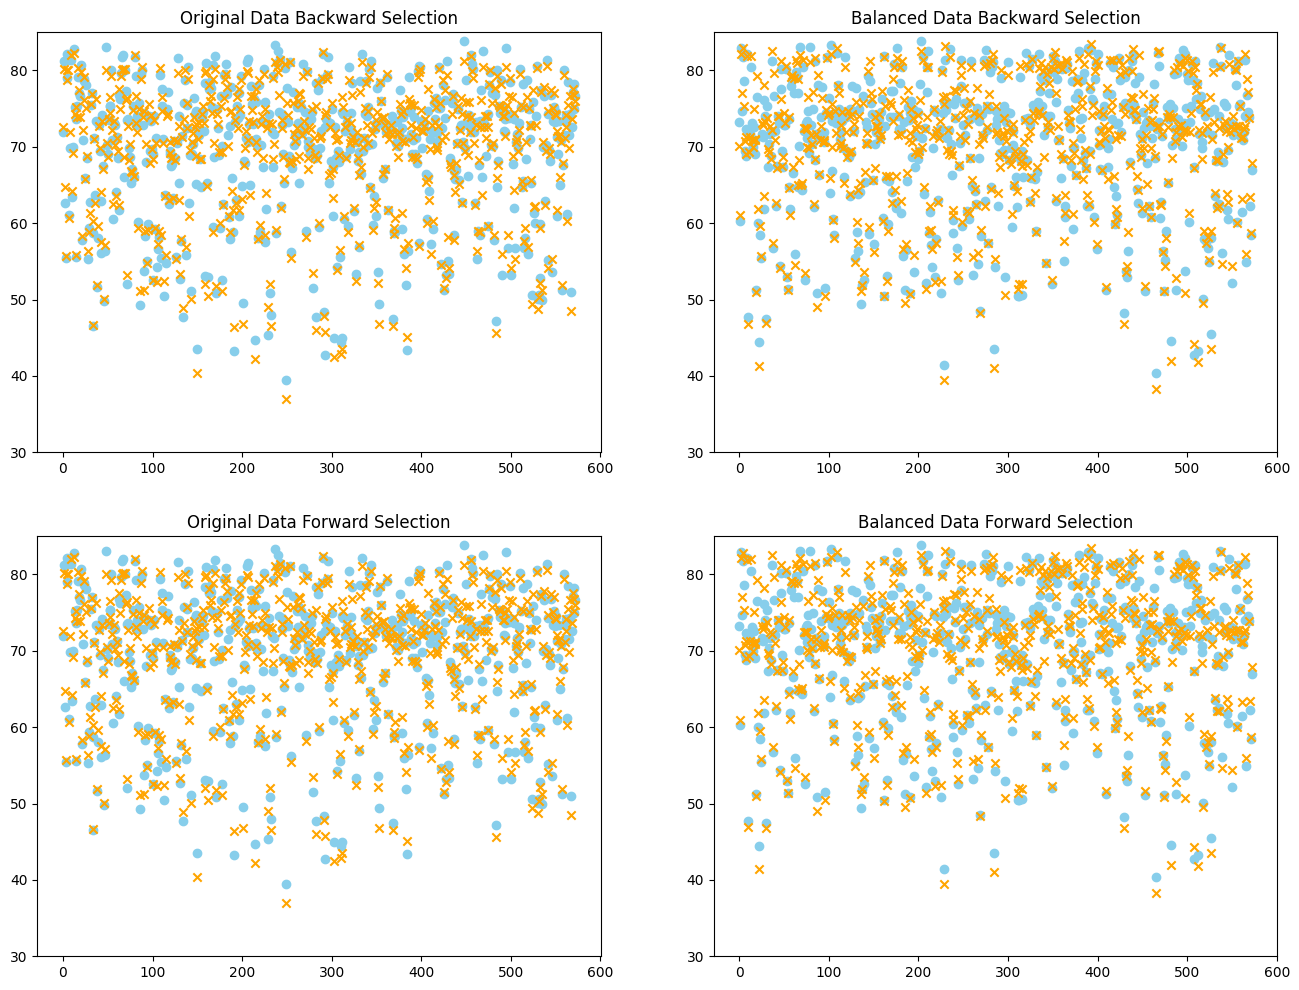

In [16]:
optimal_features = [optimal_features_og_bw, optimal_features_og_fw, optimal_features_bl_bw, optimal_features_bl_fw]
names = ["Original Data Backward Selection", "Original Data Forward Selection", "Balanced Data Backward Selection", "Balanced Data Forward Selection"]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
i = 0
j = 0
for optimals in optimal_features:
    model = LinearRegression()
    this_X = None
    this_y = None
    y_pred = None
    r_two_score = None
    if "Original" in names[i+j*2]:
        this_X = X_train_og
        this_X = pd.DataFrame(this_X, columns=X_og.columns)
        this_y = y_train_og
        test_y = y_test_og
        model.fit(this_X.iloc[:, list(optimals)], this_y)
    	
        y_pred = model.predict(X_test_og.iloc[:, list(optimals)])
        y_pred_og = y_pred
        r_two_score = model.score(X_test_og.iloc[:, list(optimals)], y_test_og)

        print(f'R² Score on Original Data: {r_two_score:.4f} for {names[i+j*2]}')

    else:
        this_X = X_train_df
        this_y = y_resampled_continuous
        test_y = y_test_continuous
        model.fit(this_X.iloc[:, list(optimals)], this_y)
    	
        y_pred = model.predict(X_test_df.iloc[:, list(optimals)])
        r_two_score = model.score(X_test_df.iloc[:, list(optimals)], y_test_continuous)
        
        print(f'R² Score on Balanced Data: {r_two_score:.4f} for {names[i+j*2]}')


    print("MSE:", mean_squared_error(test_y, y_pred))
    
        
    axes[i, j].scatter(range(0, len(test_y)), test_y, color='skyblue', marker='o')
    axes[i, j].scatter(range(0, len(y_pred)), y_pred, color='orange', marker='x')
    axes[i, j].set_title(names[i+j*2])
    # set scale of y axis to 30 - 90
    axes[i, j].set_ylim([30, 85])

    i += 1
    if i == 2:
        i = 0
        j += 1

plt.show()


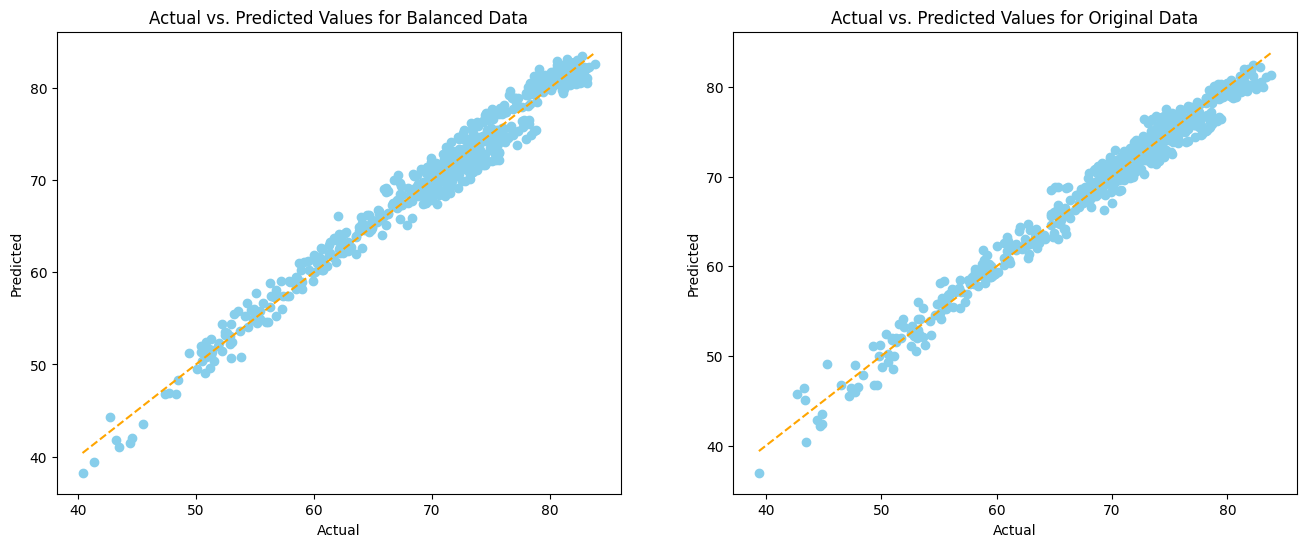

In [17]:
# put plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].scatter(y_test_continuous, y_pred, color='skyblue') 
axes[0].plot([y_test_continuous.min(), y_test_continuous.max()], [y_test_continuous.min(), y_test_continuous.max()], linestyle='--', color='orange')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Actual vs. Predicted Values for Balanced Data')

axes[1].scatter(y_test_og, y_pred_og, color='skyblue')
axes[1].plot([y_test_og.min(), y_test_og.max()], [y_test_og.min(), y_test_og.max()], linestyle='--', color='orange')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Actual vs. Predicted Values for Original Data')

plt.show()


### _Random Forest_

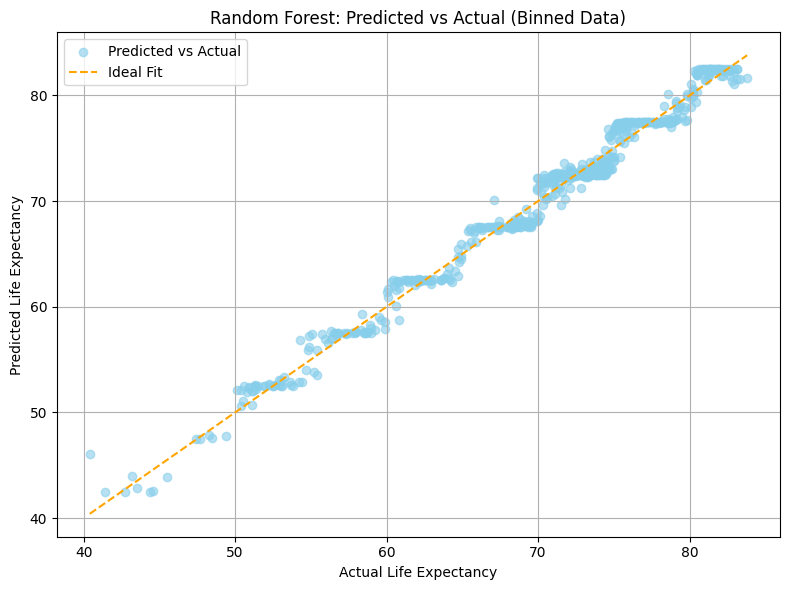

In [18]:
# Find optimal features based on BIC
min_bic_idx = np.argmin(bic_list) + 1
optimal_features_idx = list(sfs_fw.subsets_[min_bic_idx]['feature_idx'])

# Select optimal features
X_optimal_train = X_train_df.iloc[:, optimal_features_idx]
X_optimal_test = X_test_df.iloc[:, optimal_features_idx]

# Step 3: Train Random Forest on Balanced Data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_optimal_train, y_resampled_continuous)

# Generate Predictions
y_pred_rf = rf_model.predict(X_optimal_test)

# Step 5: Visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test_continuous, y_pred_rf, alpha=0.6, color='skyblue', label="Predicted vs Actual")
ax.plot([min(y_test_continuous), max(y_test_continuous)], [min(y_test_continuous), max(y_test_continuous)], color='orange', linestyle='--', label="Ideal Fit")
ax.set_title("Random Forest: Predicted vs Actual (Binned Data)")
ax.set_xlabel("Actual Life Expectancy")
ax.set_ylabel("Predicted Life Expectancy")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Calculate the R², MSE and MAE score for the Random Forest model 
# Step 4: Evaluate the Model
r2_rf = r2_score(y_test_continuous, y_pred_rf)
mse_rf = mean_squared_error(y_test_continuous, y_pred_rf)
mae = mean_absolute_error(y_test_continuous, y_pred_rf)

score_table = []

# Save scores in the table
score_table.append({
    "Model": "Random Forest on Binned Data",
    "R² Score": r2_rf,
    "Mean Squared Error (MSE)": mse_rf,
    "Mean Absolute Error (MAE)": mae
})

# Convert the score table into a pandas DataFrame for display
score_df = pd.DataFrame(score_table)

# round the scores to 3 decimal places
score_df = score_df.round(4)

score_df.head()

,Model,R² Score,Mean Squared Error (MSE),Mean Absolute Error (MAE)
0,Random Forest on Binned Data,0.9846,1.2585,0.937


### _K Nearest Neighbour_

#### Finding the best n

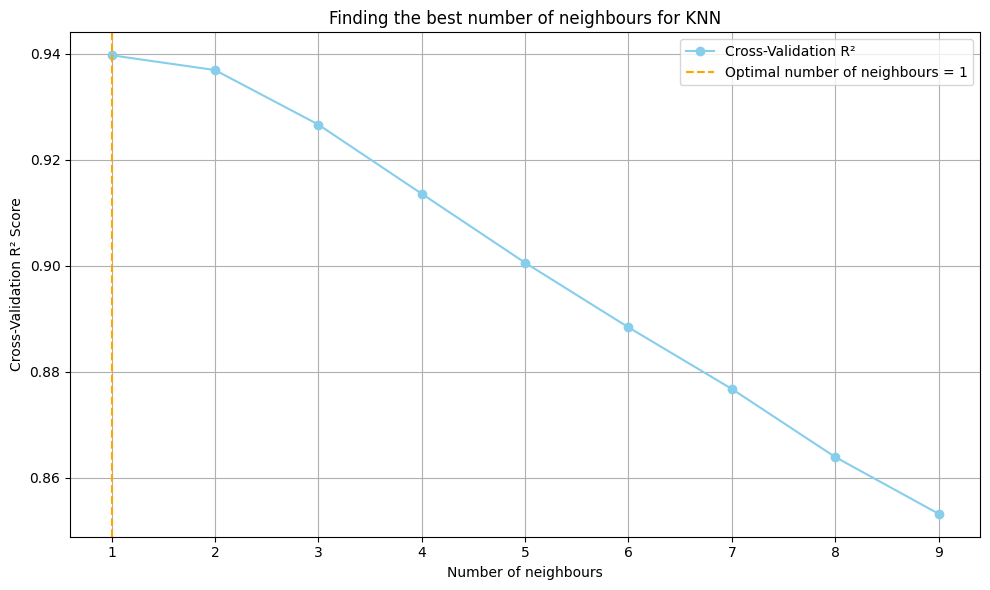

In [20]:
# Step 1: Define range of n_neighbors to test
neighbor_range = range(1, 10) 
cv_scores = []  # Store cross-validation scores

# Step 2: Loop through each n_neighbors and evaluate using cross-validation
for n in neighbor_range:
    knn = KNeighborsRegressor(n_neighbors=n)
    scores = cross_val_score(knn, X_train_df, y_resampled_continuous, cv=5, scoring='r2')  # 5-Fold Cross-Validation
    cv_scores.append(scores.mean())  # Save the average R² score

# Step 3: Find the optimal number of neighbors
best_n_neighbors = neighbor_range[np.argmax(cv_scores)]  # n_neighbors with the highest mean R²

# Step 4: Plot the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(neighbor_range, cv_scores, marker='o', linestyle='-', color='skyblue', label="Cross-Validation R²")
plt.axvline(best_n_neighbors, color='orange', linestyle='--', label=f"Optimal number of neighbours = {best_n_neighbors}")
plt.title("Finding the best number of neighbours for KNN")
plt.xlabel("Number of neighbours")
plt.ylabel("Cross-Validation R² Score")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#### Model

R² Score: 0.9666
Mean Squared Error (MSE): 2.7190
Mean Absolute Error (MAE): 1.3736


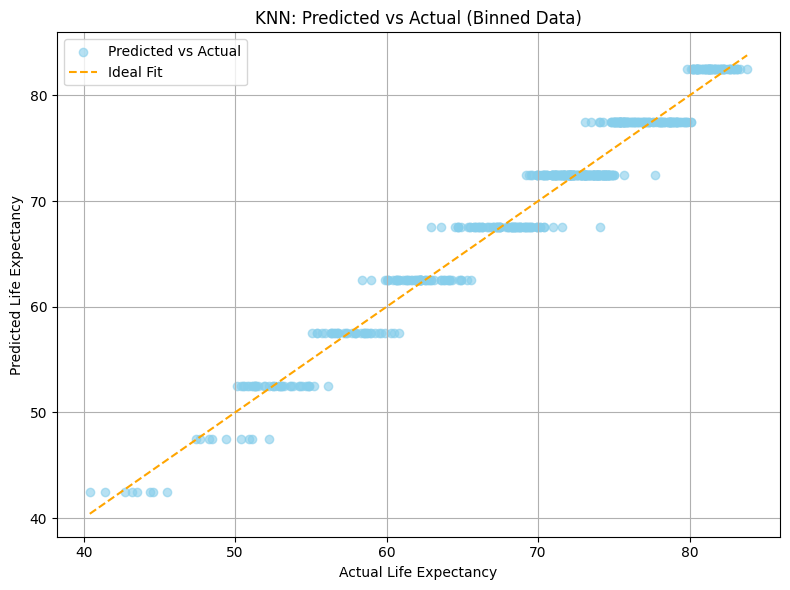

In [21]:
# Step 1: Train KNN Model
# Create KNN regressor with a chosen number of neighbors
knn_model = KNeighborsRegressor(n_neighbors=1)

# Train KNN model on the training set with optimal features
knn_model.fit(X_optimal_train, y_resampled_continuous)

# Step 2: Generate Predictions
y_pred_knn = knn_model.predict(X_optimal_test)

# Step 3: Evaluate the KNN Model
r2_knn = r2_score(y_test_continuous, y_pred_knn)
mse_knn = mean_squared_error(y_test_continuous, y_pred_knn)
mae_knn = mean_absolute_error(y_test_continuous, y_pred_knn)

# Display Results
print(f"R² Score: {r2_knn:.4f}")
print(f"Mean Squared Error (MSE): {mse_knn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_knn:.4f}")

# Step 4: Visualization
# Create a scatter plot for predicted vs actual values
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test_continuous, y_pred_knn, alpha=0.6, color='skyblue', label="Predicted vs Actual")
ax.plot([min(y_test_continuous), max(y_test_continuous)], [min(y_test_continuous), max(y_test_continuous)], color='orange', linestyle='--', label="Ideal Fit")
ax.set_title("KNN: Predicted vs Actual (Binned Data)")
ax.set_xlabel("Actual Life Expectancy")
ax.set_ylabel("Predicted Life Expectancy")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


### _Linear Regression_

R² Score: 0.9741
Mean Squared Error (MSE): 2.1117
Mean Absolute Error (MAE): 1.1734


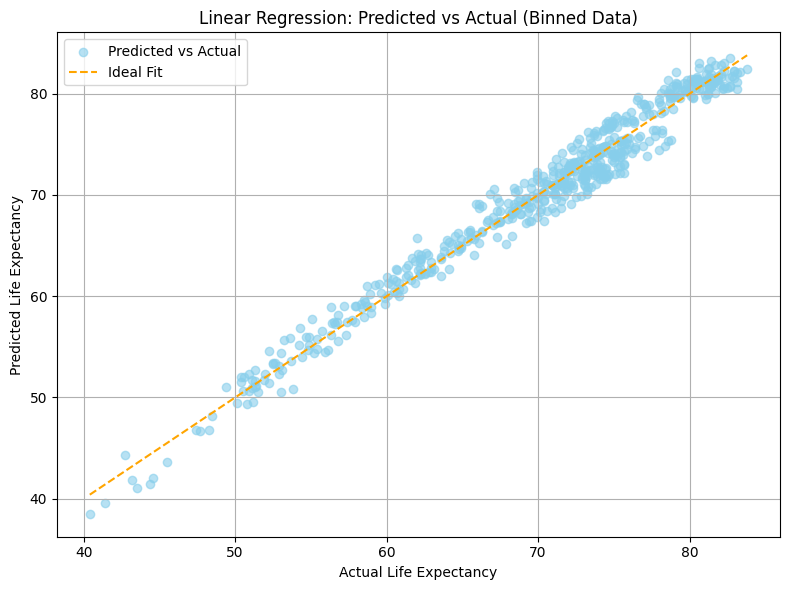

In [22]:
# Linear Regression on Transformed Data
# Train a linear regression model on the training set with optimal features
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_optimal_train, y_resampled_continuous)

# Generate Predictions
y_pred_lr = lin_reg_model.predict(X_optimal_test)

# Evaluate the Linear Regression Model
r2_lr = r2_score(y_test_continuous, y_pred_lr)
mse_lr = mean_squared_error(y_test_continuous, y_pred_lr)
mae_lr = mean_absolute_error(y_test_continuous, y_pred_lr)

# Display Results
print(f"R² Score: {r2_lr:.4f}")
print(f"Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")

# Step 4: Visualization
# Create a scatter plot for predicted vs actual values
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test_continuous, y_pred_lr, alpha=0.6, color='skyblue', label="Predicted vs Actual")
ax.plot([min(y_test_continuous), max(y_test_continuous)], [min(y_test_continuous), max(y_test_continuous)], color='orange', linestyle='--', label="Ideal Fit")
ax.set_title("Linear Regression: Predicted vs Actual (Binned Data)")
ax.set_xlabel("Actual Life Expectancy")
ax.set_ylabel("Predicted Life Expectancy")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
